Read the txt file into a dataframe

In [ ]:
import pandas as pd
import numpy as np

COLUMNS = ['comment', 'rating']
PATH = "C:/Users/Harris/Desktop/imdb_labelled.txt"
df = pd.read_csv(PATH, sep = '\t', names = COLUMNS)

Looking through the data, the comments looked pretty clean from get-go so they didn't require any further pre-processing.


In [2]:
df["comment"][600]

'It is wonderful and inspiring to watch, and I hope that it gets released again on to video or DVD.  '

Use Keras pre-processing layers to tokenize the comments (turn the text into an array of numbers). 

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 1000
max_length = 200

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df["comment"])

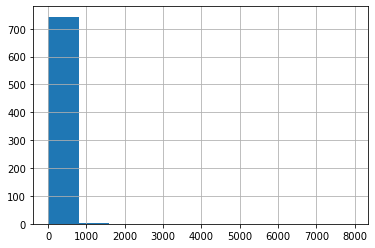

count     748.000000
mean      110.986631
std       380.627728
min         7.000000
25%        42.750000
50%        72.000000
75%       112.250000
max      7944.000000
dtype: float64

In [4]:
import matplotlib.pyplot as plt
rev_len = [len(i) for i in df["comment"]]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

We have to make sure all of the input into our Tensorflow model is the same size, so we pad the sequences to all be the same length. The padding as added at the end of the sequence. The mean length of the comments is around 110 characters (see graph above), so we chose 200 as the max length to be on the safer side and save on computation by not going higher.


In [5]:
sequences = tokenizer.texts_to_sequences(df["comment"])
padded_sequences = pad_sequences(sequences, max_length, padding = 'post')

In [6]:
padded_sequences[56]

array([248, 130, 239,  72, 438,  47,  25,   9,   1,  52,  11, 827,  17,
         1,   5, 542, 224,  48, 137,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   



Now, we split our data into training, testing, and validation sets

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df["rating"], test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [8]:
X_train

array([[  9,  35,  20, ...,   0,   0,   0],
       [  3, 278,   2, ...,   0,   0,   0],
       [184,   5,  18, ...,   0,   0,   0],
       ...,
       [136, 171,   4, ...,   0,   0,   0],
       [ 45,   4,  17, ...,   0,   0,   0],
       [ 31,  17, 281, ...,   0,   0,   0]])

In [9]:
len(X_train), len(X_test), len(y_train), len(y_test), len(X_val), len(y_val)

(508, 150, 508, 150, 90, 90)

In [ ]:
train, test = train_test_split(df, test_size = 0.2, random_state=123)
train, val = train_test_split(train, test_size=0.15, random_state=42)

train.to_csv("C:/Users/Harris/Desktop/Task2Training.csv", index=False)
test.to_csv("C:/Users/Harris/Desktop/Task2Testing.csv", index=False)
val.to_csv("C:/Users/Harris/Desktop/Task2Validation.csv", index=False)

Now, we build our Tensorflow model. For text data, we usually use an Embedding layer. I've also chosen to use bidirectional LSTM layer.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten

model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_length-1))
model.add(Bidirectional(LSTM(20, return_sequences = True)))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 199, 64)           64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 199, 40)           13600     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 87,401
Trainable params: 87,401
Non-trainable params: 0
_________________________________________________________________


Train the model

In [15]:
history = model.fit(np.array(X_train), np.array(y_train), epochs = 10, verbose = 1, batch_size=16, 
          validation_data = (np.array(X_val), np.array(y_val)))

Epoch 1/10
32/32 [==============================] - 8s 125ms/step - loss: 0.6928 - accuracy: 0.5098 - val_loss: 0.6921 - val_accuracy: 0.5444
Epoch 2/10
32/32 [==============================] - 3s 93ms/step - loss: 0.6679 - accuracy: 0.6870 - val_loss: 0.6745 - val_accuracy: 0.6000
Epoch 3/10
32/32 [==============================] - 3s 94ms/step - loss: 0.4865 - accuracy: 0.8012 - val_loss: 0.5766 - val_accuracy: 0.7111
Epoch 4/10
32/32 [==============================] - 3s 94ms/step - loss: 0.2531 - accuracy: 0.9193 - val_loss: 0.6641 - val_accuracy: 0.7000
Epoch 5/10
32/32 [==============================] - 3s 94ms/step - loss: 0.1403 - accuracy: 0.9469 - val_loss: 0.7784 - val_accuracy: 0.7333
Epoch 6/10
32/32 [==============================] - 3s 96ms/step - loss: 0.0824 - accuracy: 0.9803 - val_loss: 0.9815 - val_accuracy: 0.7111
Epoch 7/10
32/32 [==============================] - 3s 94ms/step - loss: 0.0581 - accuracy: 0.9882 - val_loss: 1.0678 - val_accuracy: 0.7222
Epoch 8/10
3

Evaluate the model on the test set

In [16]:
print("Accuracy: ", model.evaluate(np.array(X_test), np.array(y_test))[1])

5/5 [==============================] - 0s 25ms/step - loss: 0.6840 - accuracy: 0.7933
Accuracy:  0.7933333516120911


In [17]:
tokenizer.sequences_to_texts([X_test[0]])

["one more thing i can very well i'm all for freedom and of but the female character was just too much"]

In [18]:
np.round(max(model.predict(X_test[0])))

array([1.], dtype=float32)

(0, 1.1364759663119912)

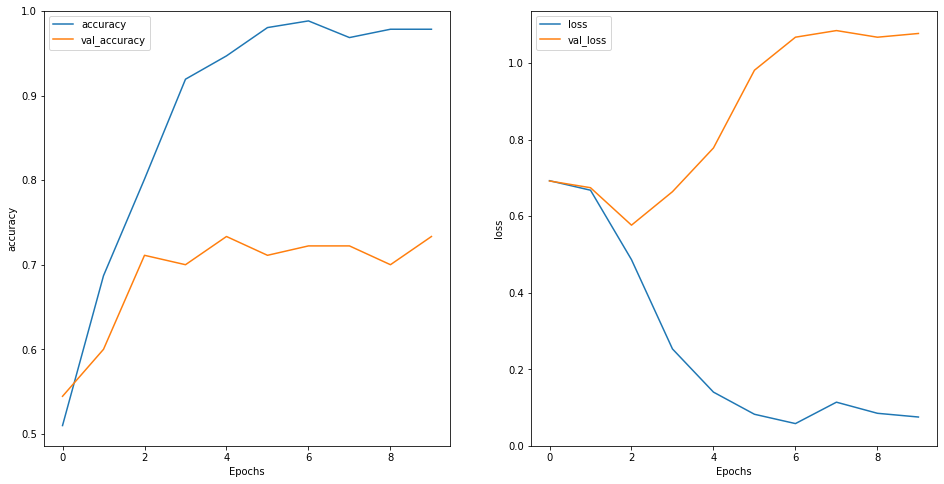

In [19]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


We can see here that accuracy increases and loss decreases as the number of epochs increases, and our overall accuracy is generally quite positive at predicting comment sentiment.